### 🔨 Hands-on II: implementing predator-prey model

Let's do some scientific programming in Julia!

- we'll implement the so-called predator-prey model
- it describes the dynamics of a biological system with two interacting species

- a predator 🦊 ...

- and a prey 🐰

### Lotka-Volterra model

The predator-prey system can be described as a system of ODEs, called a _Lotka-Volterra model_:

$$
\frac{\mathrm{d}}{\mathrm{d}t}🐰 = \alpha \cdot 🐰 - \beta \cdot 🐰 \cdot 🦊
$$

$$
\frac{\mathrm{d}}{\mathrm{d}t}🦊 = \delta \cdot 🐰 \cdot 🦊 - \gamma \cdot 🦊
$$

- $\alpha$ and $\gamma$ are prey's growth rate and predator's death rate
- $\beta$ and $\delta$ are interaction parameters between species

### Expected output

<center><img src="./figures/l1_predator-prey.png" alt="predator-prey" width="50%"/><center/>

### Tasks

1. Implement the right-hand side of Lotka-Volterra system inside the functions `dx_dt`, `dx_dt`, and `predator_prey`

2. Implement the time integration loop within a single cell
    1. Measure the execution time with the `@time` macro
    2. Experiment with the time step by changing `nt`, see how the solution changes with decreasing `Δt`

    > The implementation is very similar to the one for the Lorenz attractor from the introduction

3. Implement non-allocating version of the time integration in the function `integrate!`
    1. Split the line within the time loop into two, updating the population of each species independently
    2. Call `integrate!`, time the results with the `@time` macro, compare to the execution time in the global scope
    3. Replace `out[it-1, 1]` with `out[it, 1]` in the second line (update rule for `out[it, 2]`) to make the integration semi-implicit

Let's introduce physical parameters:

In [1]:
using CairoMakie, BenchmarkTools

# parameters
α = 1.1
β = 0.4
γ = 0.4
δ = 0.1

# total time of integration
ttot = 100.0

100.0

Then numerics:

In [2]:
nt = 1000 # increase the number of time steps to get more accurate results
Δt = ttot / nt

0.1

And initial conditions:

In [3]:
x0, y0 = 10.0, 10.0

(10.0, 10.0)

Allocate arrays to store both explicit and semi-implicit solutions

In [4]:
out1 = zeros(nt + 1, 2)
out2 = zeros(nt + 1, 2)

1001×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

Let's implement the Lotka-Volterra equations:

In [5]:
dx_dt(x, y, α, β) = α * x - β * x * y
dy_dt(x, y, γ, δ) = δ * x * y - γ * y

predator_prey(x, y, α, β, γ, δ) = dx_dt(x, y, α, β), dy_dt(x, y, γ, δ)

predator_prey (generic function with 1 method)

Now we can solve ODEs in global scope using explicit Euler integration:

In [6]:
out1[1, :] .= x0, y0
@time for it in 2:nt+1
    df_dt = predator_prey(out1[it-1, 1], out1[it-1, 2], α, β, γ, δ)
    out1[it, :] .= out1[it-1, :] .+ Δt .* df_dt
end

  0.003188 seconds (19.23 k allocations: 590.125 KiB, 78.54% compilation time)


Visualise the results:

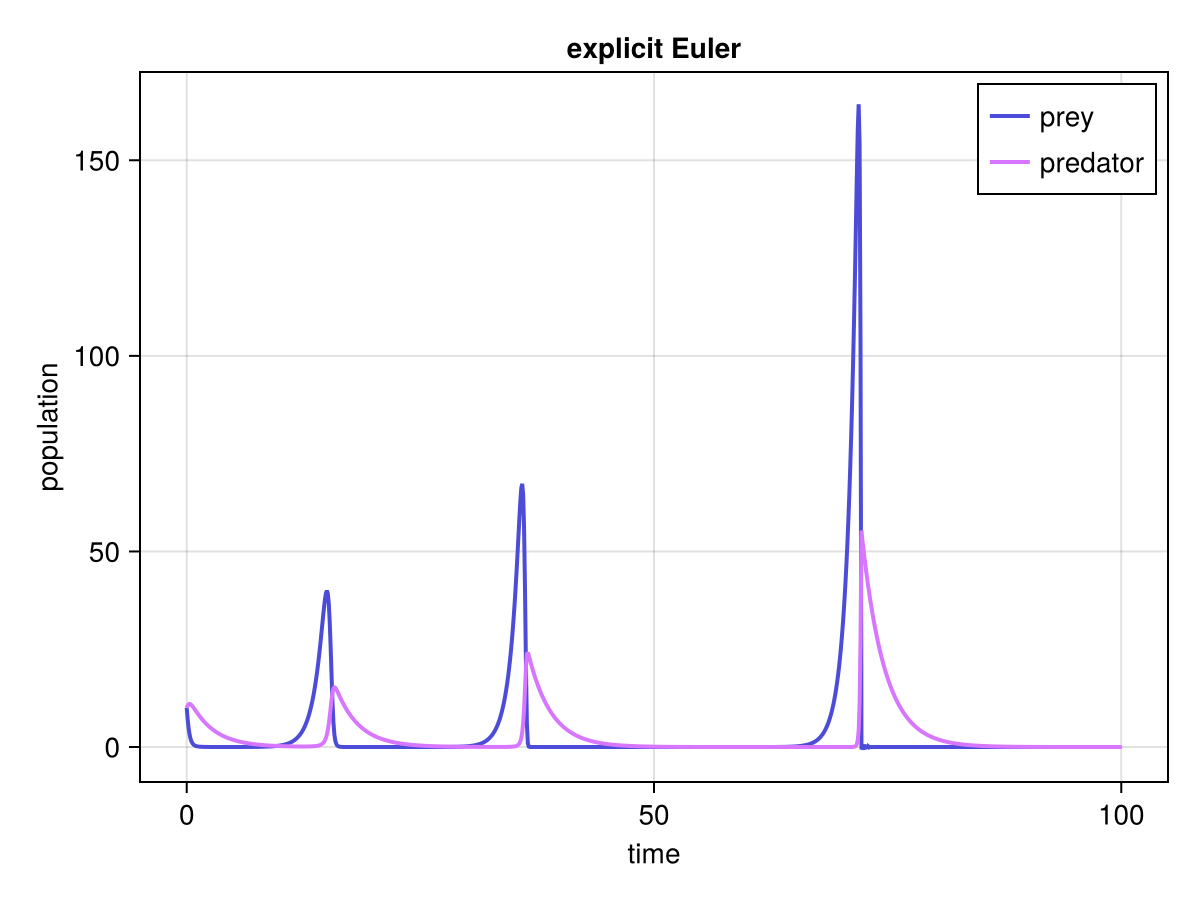

In [7]:
fig = Figure()

ax1 = Axis(fig[1, 1]; xlabel="time", ylabel="population", title="explicit Euler")

t1 = range(0, ttot, nt + 1)

series!(ax1, t1, out1'; labels=["prey", "predator"]);
axislegend(ax1);

fig

Well done! 🚀

However, the results don't look quite like we expect, both predator and prey populations seem to grow over time!

👉 Try to increase the number of time steps to `nt = 10000` and verify that the solution becomes more accurate.

Now let's implement the `integrate!` function. Use a `for` loop to avoid memory allocations:

In [8]:
function integrate!(out, x0, y0, α, β, γ, δ, Δt, nt)
    out[1, :] .= x0, y0
    for it in 2:nt+1
        out[it, 1] = out[it-1, 1] + Δt * dx_dt(out[it-1, 1], out[it-1, 2], α, β)
        out[it, 2] = out[it-1, 2] + Δt * dy_dt(out[it-1, 1], out[it-1, 2], γ, δ)
    end
    t = range(0, nt * Δt, nt + 1)
    return t, out
end

integrate! (generic function with 1 method)

Solve the same ODEs using the `integrate!` function and time the results:

In [9]:
@time t2, out2 = integrate!(out2, x0, y0, α, β, γ, δ, Δt, nt)

  0.023564 seconds (104.69 k allocations: 5.494 MiB, 99.73% compilation time)


(0.0:0.1:100.0, [10.0 10.0; 7.1 10.6; … ; 1.1762555910119854e-14 0.0006777103932472707; 1.305611819597738e-14 0.00065060197751738])

Make sure that the results are the same:

In [10]:
@assert maximum(abs.(out1 .- out2)) < eps()

There is a simple trick to make the solution much more accurate without increasing the resolution too much.

First, revert `nt` to 1000 and re-run the previous simulation.

👉 Next, make a small modification to make the time integration semi-implicit:

In [11]:
function integrate_si!(out, x0, y0, α, β, γ, δ, Δt, nt)
    out[1, :] .= x0, y0
    for it in 2:nt+1
        out[it, 1] = out[it-1, 1] + Δt * dx_dt(out[it-1, 1], out[it-1, 2], α, β)
        # hint: use the freshly computed value of x from the current time step
        # and the value of y from the previous time step
        out[it, 2] = out[it-1, 2] + Δt * dy_dt(out[it, 1], out[it-1, 2], γ, δ)
    end
    t = range(0, nt * Δt, nt + 1)
    return t, out
end

integrate_si! (generic function with 1 method)

Re-run the code and add another panel with the results:

  0.019486 seconds (104.01 k allocations: 5.212 MiB, 99.71% compilation time)


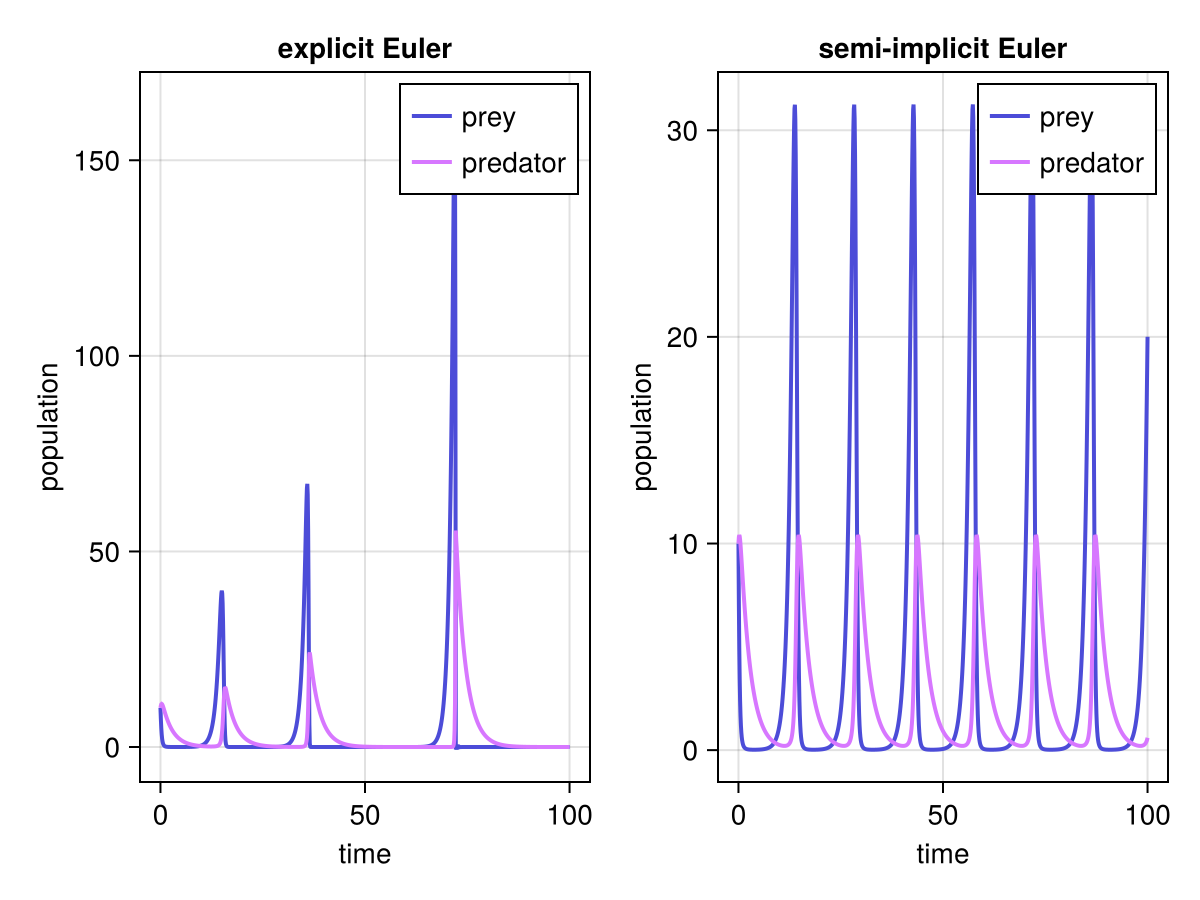

In [12]:
@time t2, out2 = integrate_si!(out2, x0, y0, α, β, γ, δ, Δt, nt)

ax2 = Axis(fig[1, 2]; xlabel="time", ylabel="population", title="semi-implicit Euler")
series!(ax2, t2, out2'; labels=["prey", "predator"])
axislegend(ax2)

fig

Much better, huh? Other way to explore the solutions to ODEs is visualising phase portraits:

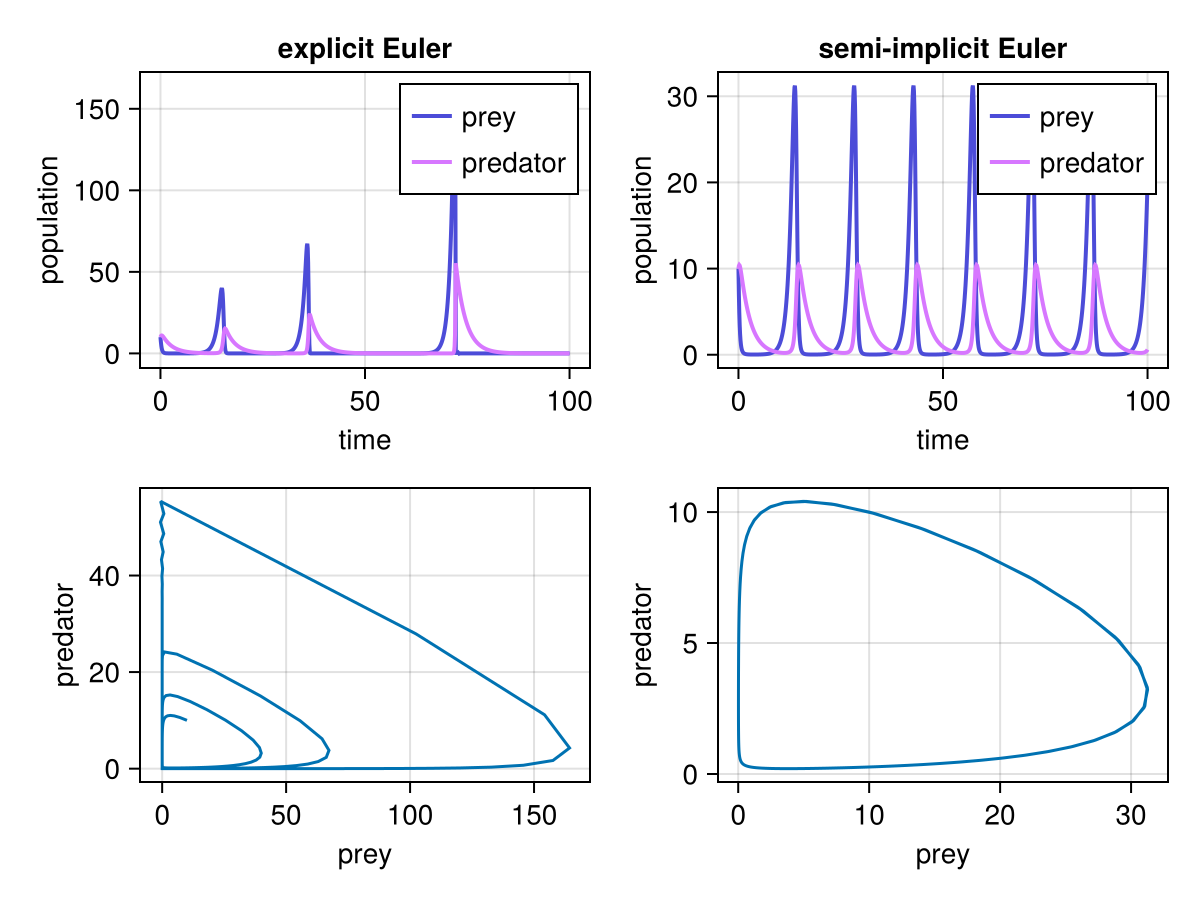

In [13]:
ax3 = Axis(fig[2, 1]; xlabel="prey", ylabel="predator")
ax4 = Axis(fig[2, 2]; xlabel="prey", ylabel="predator")

lines!(ax3, out1[:, 1], out1[:, 2])
lines!(ax4, out2[:, 1], out2[:, 2])

fig

Finally, let's benchmark the `integrate_si!` function (hint: use `@benchmark` macro and prepend each argument with '$')

In [14]:
@benchmark integrate!($out2, $x0, $y0, $α, $β, $γ, $δ, $Δt, $nt)

BenchmarkTools.Trial: 10000 samples with 4 evaluations per sample.
 Range (min … max):  7.708 μs …  34.583 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     7.750 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.941 μs ± 649.795 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▇     ▃                                                    ▁
  ███▇▆▅▆██▇▆▆▇▇▅▅▆▇███▇█▇██▇▇▇▆▅▅▄▅▆▅▅▅▆▆▇▅▆▆▅▆▆▅▇▆▆▆▄▄▃▅▃▄▄ █
  7.71 μs      Histogram: log(frequency) by time      10.6 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.